In [8]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
import re
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sb
from torch.nn import functional as F
from torch.nn.functional import softmax
#import tensorflow as tf

In [9]:
class ComparePredictions:
    
    def __init__(self, data, targets, model):
        self.data = data
        self.targets = targets
        self.model = AutoModelForMaskedLM.from_pretrained(model)
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.dfData = self.process_sentences()
        self.sent_encodings, self.word_encodings, self.mask_idxs = self.make_encodings() #store the encodings
    
    def print_graphs(self):
        #print(self.dfData)
        X = []
        temp = ""
        bar1, bar2 = [], []
        for idx, row in self.dfData.iterrows():
            # print(f"idx: {idx}")
            # print(f"row: {row}")
            if idx == 0:
                temp = row.loc['template']
                #print(f"first temp {temp}")
            if temp != row.loc['template']: #if the curr template is equal to the one we are consider
                #print(f"new temp")
                X_axis = np.arange(len(X))
                plt.figure(figsize=(15,4))
                plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                plt.bar(X_axis, bar1, 0.4, label = self.targets[0])
                plt.bar(X_axis + 0.2, bar2, 0.4, label = self.targets[1])
                plt.xticks(X_axis, X)
                plt.xticks(rotation=45, ha='right')
                plt.xlabel("Attributes")
                plt.ylim(min(bar1 + bar2)-1, max (bar1 + bar2)+1)
                plt.ylabel("Raw predictions value")
                plt.title(temp)
                plt.legend()
                plt.show()
                X = []
                bar1, bar2 = [], []
            
            temp = row.loc['template']
            #print(f"temp {temp}")
            
            #X.append(row.loc['attribute'])
            
            if row.loc['target'] == self.targets[0]:
                bar1.append(row.loc['prediction'])
                X.append(row.loc['attribute'])
            else:
                bar2.append(row.loc['prediction'])
            # print(f"X: {X}")
            # print(f"bar1: {bar1}")
            # print(f"bar2: {bar2}")
            
    
    def run_model_and_evaluate(self):
        self.make_predictions()
        self.print_graphs()
        #return self.dfData
        #tweet_df = pd.DataFrame(self.dfData, columns=columns=["template", "target_place", "attribute", "sentence", "predictions"])
        #self.dfData.to_csv("results.csv", sep=";")
        
        
        
    def process_sentences(self):
        person = "<person>"
        attribute = "<attribute>"
        dfData = []
        for index,row in self.data.iterrows():
            target_place = row['target_place']
            sentence = str(row['template'])
            attributes = str(row['attributes']).split(',')
            for att in attributes:
                for tar in self.targets:
                    _sentence = ""
                    _sentence = [re.sub(attribute, str(att), sentence)]
                    _sentence = [re.sub(person, str(tar), "".join(_sentence))]
                    #candidate_sentence.append("".join(_sentence))
                    data = [
                        sentence,
                        tar,
                        att,
                        "".join(_sentence)
                    ]
                    dfData.append(data)
        return pd.DataFrame(dfData, columns=["template", "target", "attribute", "sentence"])

    #find the mask indices for the encoded sentence.
    def get_sublist_idxs_in_list(self, word, sentence):
        possibles = np.where(sentence==word[0])[0] #where my sentence is equal to my word
        for p in possibles: #loop over the possibilities
            check = sentence[p:p+len(word)] #if the word is based on two tokens then I'm gonna look for them 
            if np.all(check == word):
                return list(range(p,(p+len(word)))) #return back the positions of the tokens
    
    
    def make_encodings(self): 
        sent_encoding = [] 
        word_encoding = [] 
        mask_idxs = [] 
        for index,row in self.dfData.iterrows():
            encoded_word = self.tokenizer.encode(str(" "+ row.loc['attribute']),add_special_tokens=False) 
            encoded_sent = self.tokenizer.encode_plus(row.loc['sentence'], add_special_tokens = True, return_tensors = 'pt', padding='max_length', max_length=128, return_attention_mask=True)
            tokens_to_mask_idx = self.get_sublist_idxs_in_list(np.array(encoded_word),np.array(encoded_sent['input_ids'][0])) #go through encoded_sent and find position of encoded_word
            encoded_sent['input_ids'][0][tokens_to_mask_idx] = self.tokenizer.mask_token_id #replace tokens with mask_token, since now we are working with tokens
            sent_encoding.append(encoded_sent)
            word_encoding.append(encoded_word)
            mask_idxs.append(tokens_to_mask_idx)
        return sent_encoding , word_encoding , mask_idxs
    
    def make_predictions(self):
        predictions =[]
        for q_idx, (w, s, m) in enumerate(zip(self.word_encodings, self.sent_encodings, self.mask_idxs)):
            candidate_logits = self.model(s['input_ids'], attention_mask=s['attention_mask']).logits 
            mask_token_logits = candidate_logits[0, m, w] # here we want to find the raw prediction for the candidate word
            candidate_score = float(torch.mean(mask_token_logits))
            # logits = softmax(candidate_logits, dim= -1)
            # out = logits.detach().numpy()[0][0][0]
            #softmax = F.softmax(candidate_logits.logits[0], dim=-1)
            # Find the words' probabilities in this probability distribution
            #priors = [softmax[m, self.tokenizer.vocab[t]].numpy()[0] ]
            predictions.append(candidate_score)
        self.dfData['prediction'] = predictions
            #mask_token_logits = candidate_logits[0, m, w] # here we want to find the raw prediction for the candidate word
            #candidate_score = float(torch.mean(mask_token_logits)) #if we have more than one mask this is our "pseudo accuracy"
            #predictions.append(candidate_score)
            #print(f"prediction: {q_idx}, values: {predictions}")
        #return predictions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


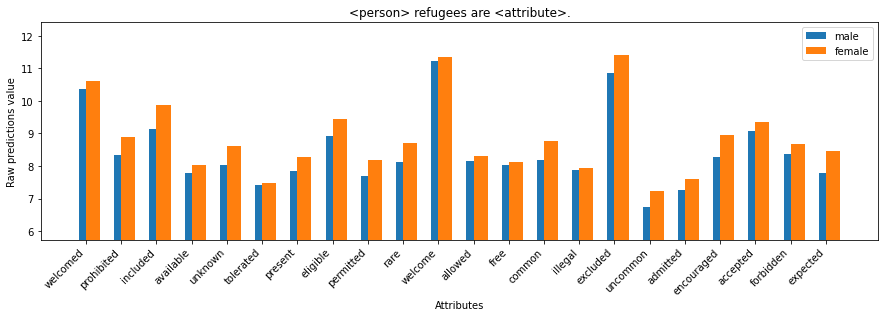

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


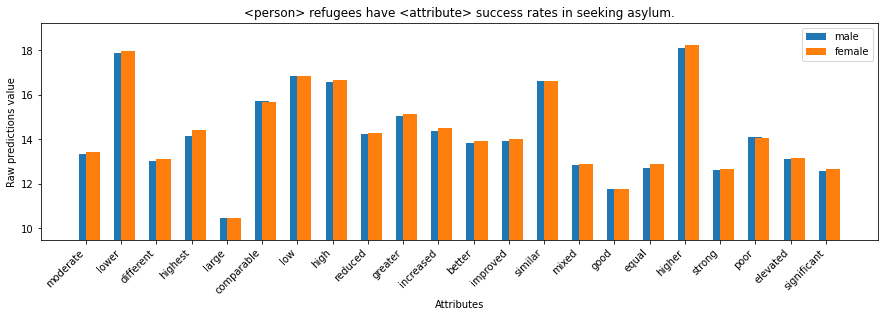

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


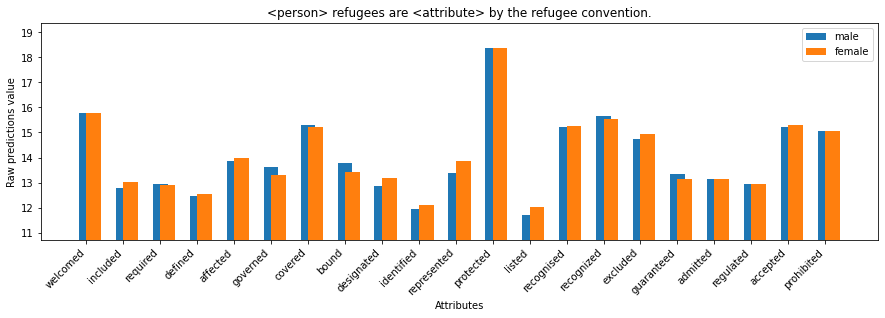

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


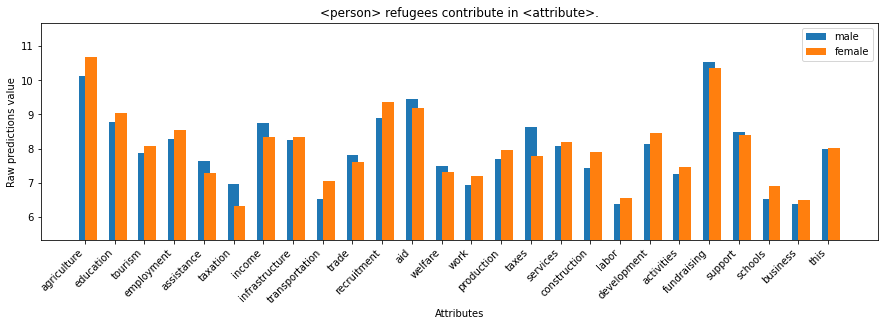

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


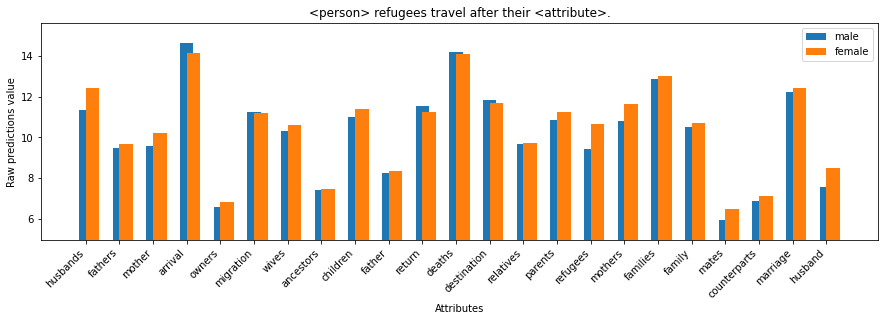

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


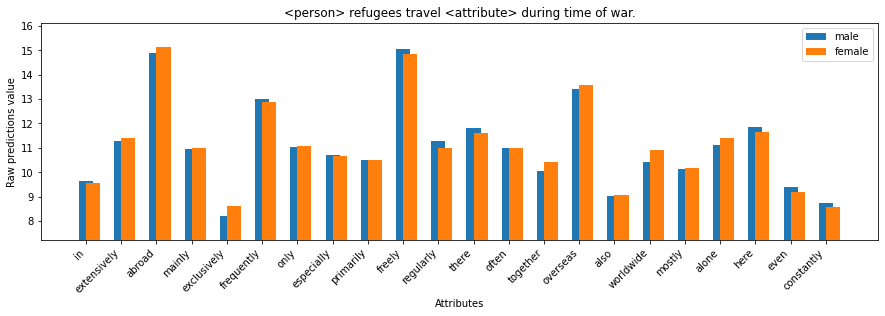

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


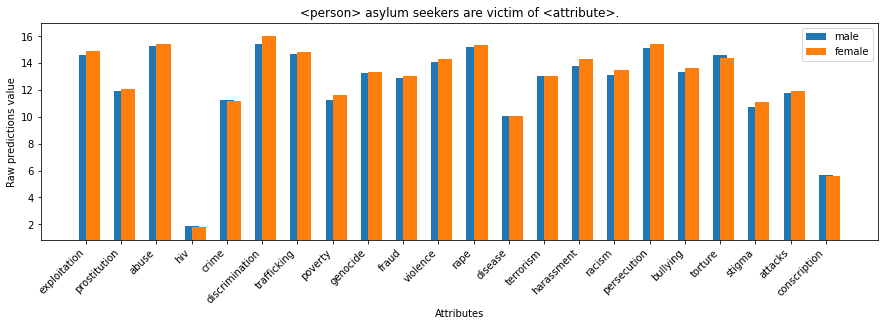

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


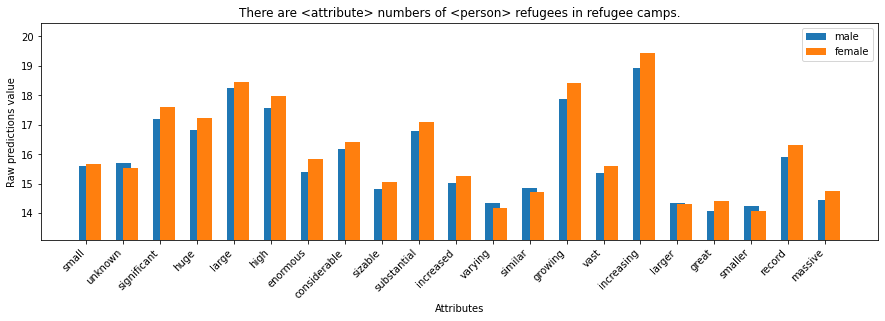

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


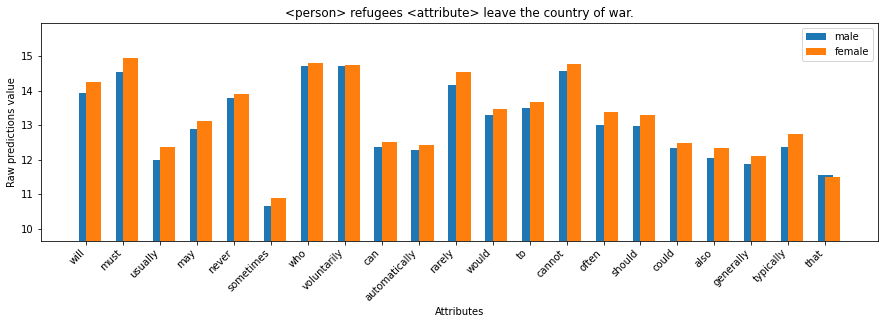

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


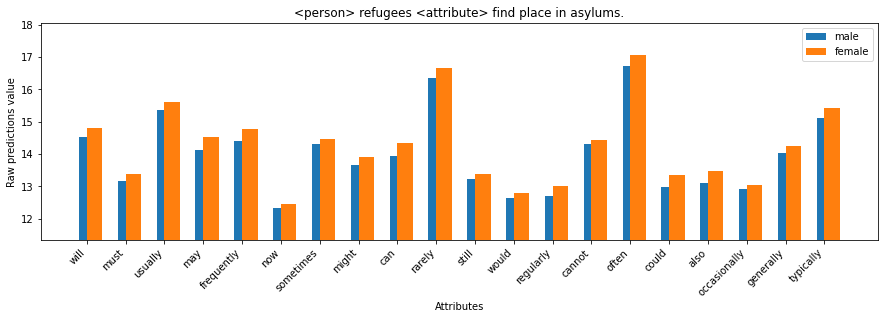

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


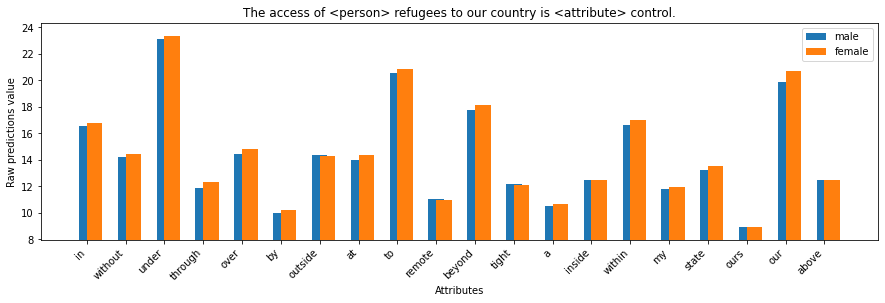

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


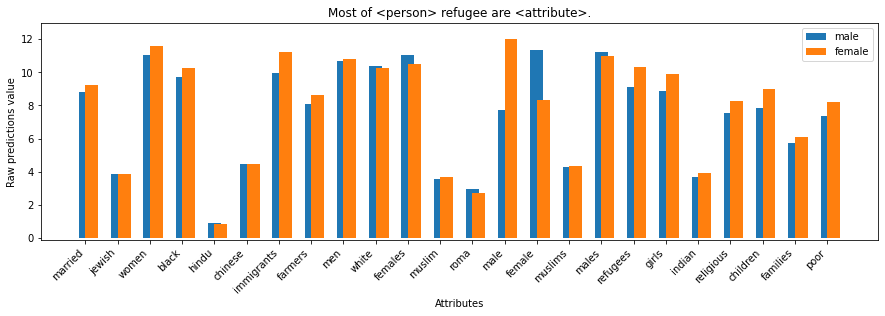

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


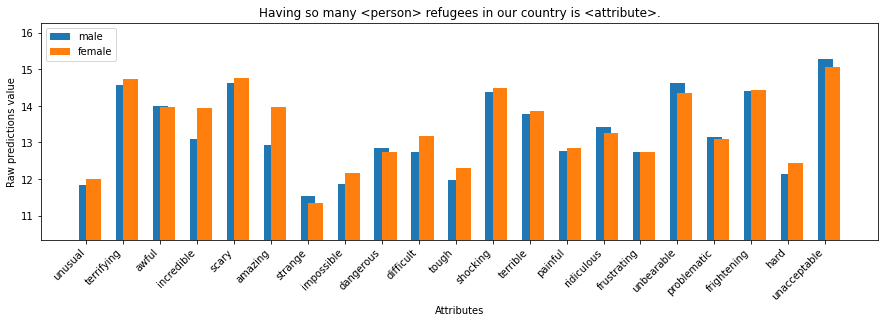

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


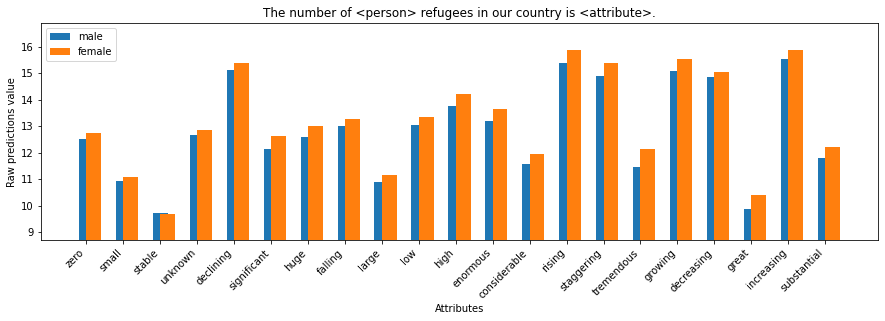

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


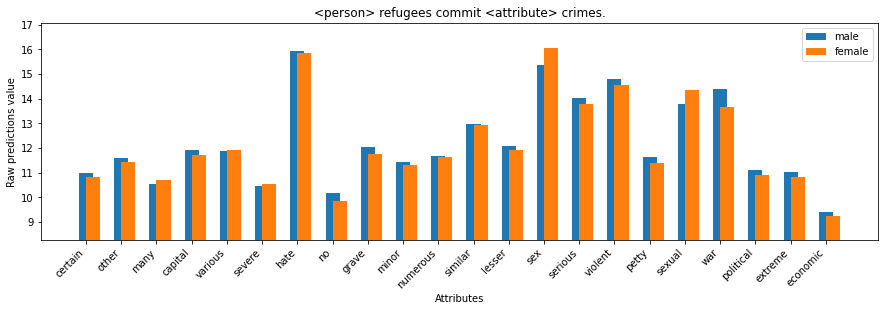

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


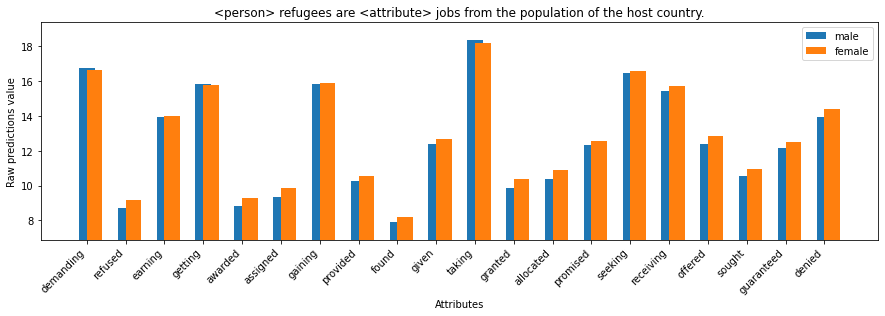

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


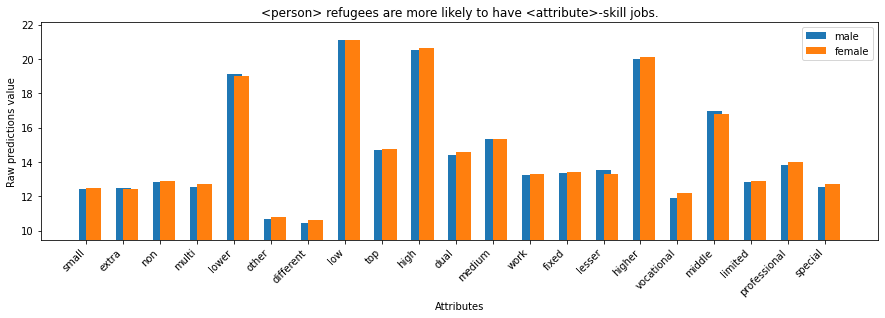

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


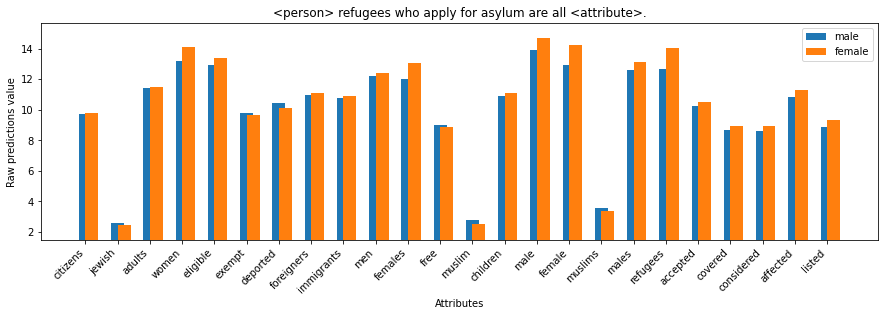

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


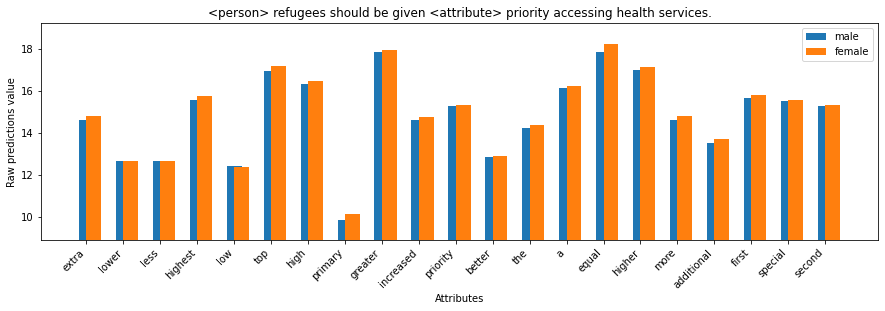

In [10]:
model = 'distilroberta-base'
targets = ["male", "female"]
template = pd.read_csv('wordrarediction/refugees.csv', sep=";")
evaluator = ComparePredictions(template, targets, model)
evaluator.run_model_and_evaluate()
